In [87]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from functools import reduce
import warnings
import cv2
import pandas as pd
warnings.filterwarnings('ignore')

def getGrayScaledImage(path):
    img = cv2.imread(path)
    
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax1.imshow(img); ax1.set_xlabel("Original")
    
    img = np.array(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
  
    ax2 = fig.add_subplot(122)
    ax2.imshow(img, cmap='gray'); ax2.set_xlabel("Grayscaled")
    
    return img
    
def operatorKernels(getGrayScaledImage):
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    return (kernel_x, kernel_y)
    
def coordinatesDirection(img, kernel_x, kernel_y):
    G_x = sig.convolve2d(img, kernel_x, mode='same') 
    G_y = sig.convolve2d(img, kernel_y, mode='same') 
    return (G_x, G_y)
    
def plotImages(G_x, G_y):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.imshow((G_x + 255) / 2, cmap='gray'); ax1.set_xlabel("Gx")
    ax2.imshow((G_y + 255) / 2, cmap='gray'); ax2.set_xlabel("Gy")
    plt.show()

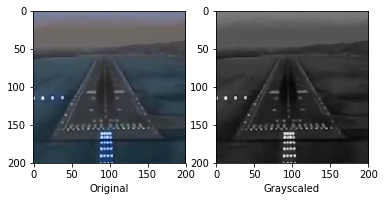

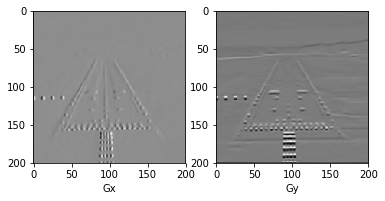

0   degrees : 25.821458041670446
20   degrees : 41.24222614746929
40   degrees : 151.76523357938046
60   degrees : 456.9262094941352
80   degrees : 490.3115838386782
100   degrees : 688.4763077691804
120   degrees : 0.0
140   degrees : 0.0
160   degrees : 0.0


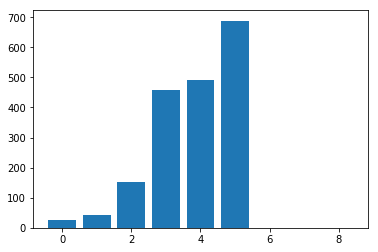

In [123]:
number_patches = 9 # 0..20..40..160
cell_size = 8 
block_size = 2


def gradientMagnitude(loc_x, loc_y, G_x, G_y):
    x_cell_pos = G_x[loc_x:loc_x + cell_size, loc_y:loc_y + cell_size]
    y_cell_pos = G_y[loc_x:loc_x + cell_size, loc_y:loc_y + cell_size]
    gradient_magnitude = np.sqrt(np.power(x_cell_pos, 2) + np.power(y_cell_pos, 2))
    return gradient_magnitude

def gradientDirection(loc_x, loc_y, G_x, G_y):
    x_cell_pos = G_x[loc_x:loc_x + cell_size, loc_y:loc_y + cell_size]
    y_cell_pos = G_y[loc_x:loc_x + cell_size, loc_y:loc_y + cell_size]
    gradient_direction = np.abs(np.arctan(y_cell_pos / x_cell_pos) * (180/np.pi))
    return gradient_direction     


def cellHistogramHOG(grdnt_direction, grdnt_magnitude):
    patches = np.linspace(0,180, number_patches + 1)
    hog_cell_hist = np.zeros(number_patches)
    cell_size = grdnt_direction.shape[0]
    for r_it in range(cell_size):
        for c_it in range(cell_size):
            tmp_direction = grdnt_direction[r_it, c_it]
            tmp_magnitude = grdnt_magnitude[r_it, c_it]
            mns = np.abs(tmp_direction - patches)
            if tmp_direction < patches[0]:
                first_patch_index = 0
                second_patch_index = patches.size - 1
            elif tmp_direction > patches[-1]:
                first_patch_index = patches.size - 1
                second_patch_index = 0
            else:
                first_patch_index = np.where(mns == np.min(mns))[0][0]
                tmp = patches[[(first_patch_index - 1)% patches.size, (first_patch_index + 1) % patches.size]]
                tmp2 = np.abs(tmp_direction - tmp)
                res = np.where(tmp2 == np.min(tmp2))[0][0]
                if res == 0 and first_patch_index != 0:
                    second_patch_index = first_patch_index - 1
                else:
                    second_patch_index = first_patch_index + 1
            first_patch_value = patches[first_patch_index]
            second_patch_value = patches[second_patch_index]
            hog_cell_hist[first_patch_index] = hog_cell_hist[first_patch_index] + (np.abs(tmp_direction - first_patch_value)/(180.0/patches.size)) * tmp_magnitude
            hog_cell_hist[second_patch_index] = hog_cell_hist[second_patch_index] + (np.abs(tmp_direction - second_patch_value)/(180.0/patches.size)) * tmp_magnitude
#     for degree in hog_cell_hist:
#         print (degree, sep = " ")
    
    for elem in list(enumerator(hog_cell_hist, 0, 20)):
        print(str(elem[0]) + "   degrees : " + str(elem[1]))
    return hog_cell_hist

def enumerator(xs, start, step = 20):
    for x in xs:
        yield(start, x)
        start += step
        
        
        
def plotGraphics(value):
    plt.bar(x = np.arange(9), height = value, align = "center", width = 0.8)
    plt.show()
    
    
def calculateHOG():
    g_image = getGrayScaledImage("./Images/00101.png");
    x, y = operatorKernels(g_image)
    g_x, g_y = coordinatesDirection(g_image, x , y)
    plotImages(g_x, g_y)
    magnitude = gradientMagnitude(50, 50, g_x, g_y)
    direction = gradientDirection(50, 50, g_x, g_y)
    value = cellHistogramHOG(direction, magnitude)
    plotGraphics(value)
    
calculateHOG()    
    
